<a href="https://colab.research.google.com/github/rohitnikam1/Fastai-projects/blob/master/multi_label_classification_and_image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.6 MB/s 
     |████████████████████████████████| 1.2 MB 10.4 MB/s 
     |████████████████████████████████| 188 kB 23.1 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 51 kB 301 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

Multi-label classification refers to the problem of identifying the categories of objects in images that may not contain exactly one type of object. There may be more than one kind of object, or there may be no objects at all in the classes that you are looking for.

For our example we are going to use the PASCAL dataset, which can have more than one kind of classified object per image.

We begin by downloading and extracting the dataset as per usual:


In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV (comma-separated values) file telling us what labels to use for each image. We can inspect the CSV file by reading it into a Pandas DataFrame:

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


The list of categories in each image is shown as a space-delimited string. Now that we have seen what the data looks like, let's make it ready for model training.

# Constructing a DataBlock

Here we will convert from Pandas `DataFrame` object to `DataLoaders`  object. 

PyTorch and fastai have two main classes for representing and accessing a training set or validation set:

- `Dataset`:  A collection that returns a tuple of your independent and dependent variable for a single item
- `DataLoader`: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple containing a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

- `Datasets`: An object that contains a training `Dataset` and a validation `Dataset`
- `DataLoaders`: An object that contains a training `DataLoader` and a validation `DataLoader`


`DataLoaders` object can be created using `DataBlock` API as follows:

In [5]:
dblock = DataBlock()

We can create a Datasets object from this. The only thing needed is a source, which in this case, our DataFrame:

In [6]:
dsets = dblock.datasets(df)

This contains a train and a valid dataset, which we can index into:

In [7]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [13]:
x,y = dsets.train[0]
print(x,y, sep=2*'\n')

fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object

fname       008663.jpg
labels      car person
is_valid         False
Name: 4346, dtype: object


this simply returns a row of the DataFrame, twice. 

This is because by default, the data block assumes we have two things: input and target. 

We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing `get_x` and `get_y` functions:

In [15]:
def get_x(r): return r['fname']
def get_y(r): return r['labels']

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

The independent variable (x) will need to be converted into a complete path, so that we can open it as an image, and the dependent variable (y) will need to be split on the space character (which is the default for Python’s `split` function) so that it becomes a list.

In [16]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

dblock = DataBlock(get_x=get_x, get_y=get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002549.jpg'), ['tvmonitor'])

`DataBlock` provides the functionality to actually open the image and do the conversion to tensors. It does it in terms of defining a block within its definition, which in this case is `ImageBlock`.

Multiple labels for each item can be contained in the `MultiCategoryBlock`.

In [17]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

As can be seen, the list of categories (independent variable) is encoded as **one-hot encoding**. Let’s check what the categories represent for this example:

In [21]:
idx = torch.where(dsets.train[0][1] == 1)[0]
dsets.train.vocab[idx]

(#1) ['train']

We have ignored the column `is_valid` in the DataFrame `df` up until now, which means that `DataBlock` has been using a random split by default. 

To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter` (or use one of fastai's predefined functions or classes). 

It will take the items (here our whole DataFrame) and must return two (or more) lists of integers:

In [25]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

In [26]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x, get_y=get_y, 
                   splitter=splitter)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Now `DataLoader` assembles items from the `Dataset` into mini-batches.

We also have to ensure that every item is of the same size. To do this, we can use `RandomResizedCrop`:

In [27]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

In [44]:
dls.train.one_batch()

(TensorImage([[[[ 0.0227,  0.1254,  0.1768,  ...,  1.6495,  1.6324,  1.6495],
           [-0.7308, -0.0116,  0.2453,  ...,  1.6667,  1.6495,  1.6667],
           [-0.8678, -0.0287,  0.2111,  ...,  1.6838,  1.6667,  1.6667],
           ...,
           [ 1.8893,  1.8722,  1.9064,  ...,  1.8722,  1.8208,  1.8550],
           [ 1.9749,  1.9235,  1.9407,  ...,  1.9407,  1.9749,  1.9235],
           [ 1.7694,  1.8550,  1.8208,  ...,  1.7009,  1.7009,  1.5982]],
 
          [[ 0.3803,  0.4153,  0.5728,  ...,  2.0959,  2.0959,  2.0959],
           [-0.2325,  0.3102,  0.5378,  ...,  2.1310,  2.1134,  2.1134],
           [-0.2325,  0.4153,  0.5728,  ...,  2.1310,  2.1134,  2.1134],
           ...,
           [ 2.0259,  2.0084,  2.0434,  ...,  1.9734,  1.9384,  1.7808],
           [ 2.0784,  2.0259,  2.0434,  ...,  2.0434,  2.0784,  2.0259],
           [ 1.8859,  1.9734,  1.9209,  ...,  1.7633,  1.7808,  1.7808]],
 
          [[ 0.8274,  0.9494,  1.0191,  ...,  2.5877,  2.5877,  2.5877],
        

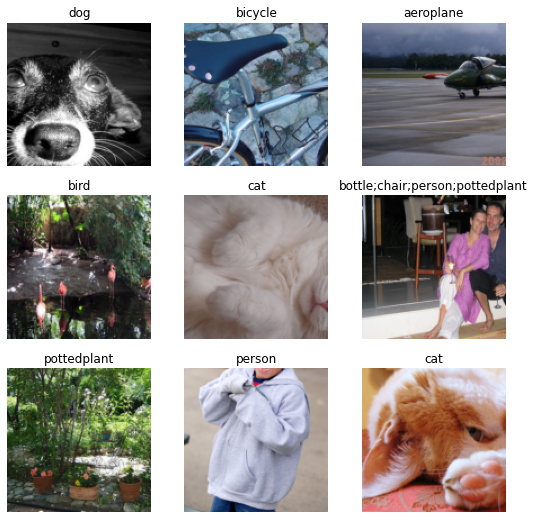

In [33]:
dls.show_batch()

Our data is now ready for training a model. By default, fastai will pick the loss function for this case as **Binary Cross Entropy**

## Binary Cross Entropy

Now we'll create our `Learner`.

In [34]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Let's now pass one mini-batch of the dataloader to the CNN model in the learner. It will return activations from final layer.

In [50]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

The shape of `activs` looks like this, because we have a batch size of 64 for dataloader `dls`, and we need to calculate the probability of each of 20 categories. Here’s what one of those activations looks like:

In [54]:
activs[0]

tensor([-4.8365e+00, -3.0871e+00,  2.5713e+00, -2.7309e+00,  3.4451e+00, -9.1141e-01, -6.3009e-01, -1.5767e+00,  2.5074e+00, -2.4206e+00, -5.4086e-01,  3.8352e-01, -1.2860e+00,  2.3034e+00,
         1.3768e+00, -1.9194e-03,  3.6544e+00, -5.1809e-01,  8.3715e-01,  4.9949e-01], grad_fn=<SelectBackward>)

*Getting model activations*: Knowing how to manually get a mini-batch and pass it to the model, and looking at the activations and loss, is very important for debugging a model.

The activations are not scaled between 0 and 1, which we will do now:

In [57]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, 1-inputs, inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entropy`):

- `softmax` pushes one activation to be much larger than others and needs the sum of activations to be 1. But in multiple category cases, it is not compatible. Also if none of the categories appear in an image, we may want the sum to be *less* than 1.

- `nll_loss` returns only a single activation corresponding to a single label. But we have multiple labels.

We will use PyTorch's default loss function for multiple categories, which is the same as the above `binary_cross_entropy`, called `nn.BCEWithLogitsLoss`.

In [59]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0570, grad_fn=<AliasBackward>)

fastai takes this function by default for multiple categories.

We now decide a metric.

For multicategorical classification, we use the following accuracy function:

In [60]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  "Compute accuracy when `inp` and `targ` are the same size."
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh) == targ.bool()).float().mean()

We might want to adjust that default threshold (`thresh`) and create a new version of `accuracy_multi` that has a different default. For that we can use `partial`. It allows us to bind a function with some arguments or keyword arguments, making a new version of that function.

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric:

In [61]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941056,0.708563,0.226434,00:39
1,0.821604,0.558780,0.289223,00:39
2,0.603907,0.200059,0.828446,00:39
3,0.360018,0.124423,0.942151,00:39


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132219,0.120862,0.944124,00:44
1,0.116929,0.110023,0.952809,00:44
2,0.099179,0.104052,0.953068,00:44


Picking a threshold is important. If we pick  `thresh` too low, we cannot select correctly labeled objects. We can see this by changing our metric, and then calling `validate`, which returns the validation loss and metrics:

In [62]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.1040516048669815,0.9339242577552795]

If we pick `thresh` too high, we will only select objects which the model is highly confident about.

In [63]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.1040516048669815,0.9444621205329895]

We can judge the best `thresh` by taking predictions first:

In [64]:
preds, targs =  learn.get_preds()

Then we can call the metric directly.

By default `get_preds` applies the output activation function (`sigmoid`, in this case) for us, so we'll need to tell accuracy_multi to not apply it:

In [65]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorMultiCategory(0.9574)

We can now use this approach to find the best threshold level:

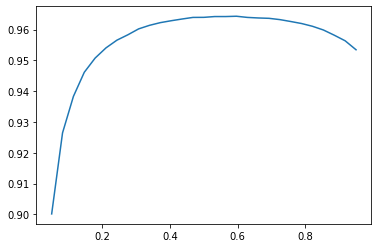

In [68]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

- In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set.

- Changing `thresh` results in a smooth curve, so we're not picking some inappropriate outlier `thresh`.

We now choose `thresh` which gives highest accuracy and train the model again:

In [69]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.934396,0.702463,0.621295,00:39
1,0.818683,0.562506,0.736932,00:39
2,0.604714,0.203424,0.949064,00:39
3,0.361316,0.124040,0.957291,00:40


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132096,0.115131,0.960757,00:44
1,0.116169,0.107635,0.962450,00:44


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132096,0.115131,0.960757,00:44
1,0.116169,0.107635,0.962450,00:44
2,0.097157,0.101735,0.963725,00:44


We see that the accuracy is slightly improved.

# Image Regression

Deep learning models have been conventionally classified into domains such as computer vision, NLP, etc. However, there is a far wider variety of models than that. E.g., an independent variable that's text and dependent that's an image (e.g., generating an image from a caption); or perhaps images, texts, and tabular data as independent variables, and predicting product purchases.

In order to craft novel solutions to such novel problems, it helps to really understand the `DataBlock` API from fastai.

Here, we will consider one of such problems -- image regression.
We're going to do a key point model. A key point refers to a specific location represented in an image -- in this case, we'll use images of people and we'll be looking for the center of the person's face in each image. That means we'll actually be predicting two values for each image: the row and column of the face center.

We will use the [Biwi Kinect Head Pose dataset](https://icu.ee.ethz.ch/research/datsets.html) for this section. We'll begin by downloading the dataset as usual:

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [26]:
Path.BASE_PATH = path

In [27]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

There are 24 directories numbered from 01 to 24 (they correspond to the different people photographed), and a corresponding .obj file for each (we won't need them here). Let's take a look inside one of these directories:

In [75]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

Let's take a look at our first image:

In [7]:
img_files = get_image_files(path)
im = PILImage.create(img_files[0])
im.shape

(480, 640)

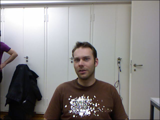

In [10]:
im.to_thumb(160)

The Biwi dataset website used to explain the format of the pose text file associated with each image, which shows the location of the center of the head. The details of this aren't important for our purposes, so we'll just show the function we use to extract the head center point. But first, it needs a function that converts an image filename to its associated pose file, which we will define first:

In [11]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('14/frame_00424_pose.txt')

In [28]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

This function returns the coordinates as a tensor of two items:

In [29]:
get_ctr(img_files[0])

tensor([339.7299, 248.4473])

We can pass this function to `DataBlock` as `get_y`, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

We will not be using a random splitter to split training and validation datasets here. Same people appear in multiple images in this dataset, but we want to ensure that our model can generalize to people that it has not seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference from the previous data block examples is that the second block is a `PointBlock`. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [30]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)),
                             Normalize.from_stats(*imagenet_stats)]
                 )

Before doing any modelling, let's make sure the data looks okay.

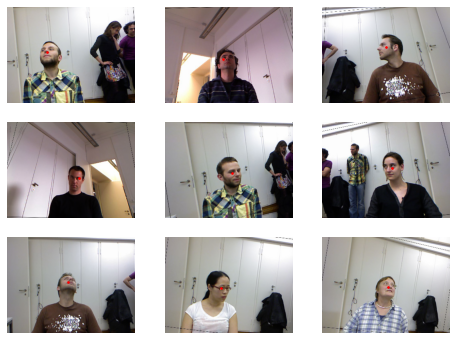

In [19]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

Let's also look at the underlying tensors:

In [20]:
xb,yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [23]:
yb[0]

TensorPoint([[0.1280, 0.1700]], device='cuda:0')

As can be seen, we have not used any separate image regression application here. All we have done is to label the data and tell fastai what kind of data do independent and dependent variables represent.

## Training a model

In [31]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Since we're predicting a continuous number, rather than a category, we have to tell fastai what range our target has, using the `y_range` parameter.

The loss function that fastai has picked for us by default is:

In [32]:
dls.loss_func

FlattenedLoss of MSELoss()

`MSELoss` or Mean Square Loss makes sense for the current dependent variable - coordinates.

Also, we have not specified any metric, since MSE is already a useful metric for this case.

Let's get a good learning rate using learning rate finder:

SuggestedLRs(valley=0.001737800776027143)

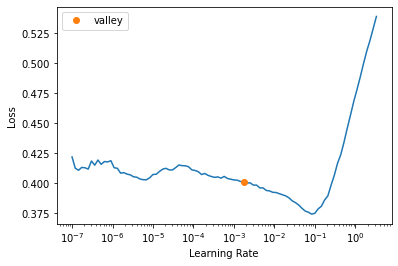

In [34]:
learn.lr_find()

In [35]:
lr = 0.001737800776027143
learn.fine_tune(3, base_lr=lr)

epoch,train_loss,valid_loss,time
0,0.155534,0.017640,03:33


epoch,train_loss,valid_loss,time
0,0.015359,0.002559,04:42
1,0.004102,0.001345,04:42
2,0.002776,0.000184,04:42


A loss of around 0.0001, which corresponds to an average coordinate prediction error of:

In [36]:
math.sqrt(0.0001)

0.01

This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (ground truth) coordinates and the right side are our model's predictions:

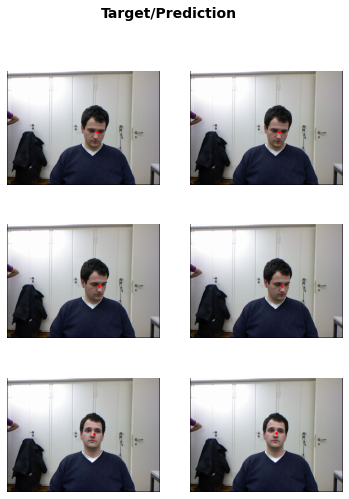

In [49]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

- Using the tools of flexible `DataBlock` API and transfer learning, we thus have been able to create such an accurate key point model in just few minutes.

- Note that our pre-trained model was trained for image classification, while we fine tuned it to do image regression.

- In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. 

- The loss function is the one thing that changes, which is why it's important to double-check that the right loss function is being used for a certain problem.

- We most probably want
  - `nn.CrossEntropyLoss` for single-label classification
  - `nn.BCEWithLogitsLoss` for multi-label classification
  - `nn.MSELoss` for regression

